In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed Apr  7 19:20:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
path = '/content/drive/My Drive/FedPerf/'
os.makedirs(path, exist_ok=True)

Mounted at /content/drive


## Load the MNIST Dataset

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = MNIST(root = '../data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = MNIST(root = '../data/mnist/', train=False, download=True, transform=transforms_mnist)

--2021-04-07 19:21:18--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-07 19:21:18--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [      <=>           ]  33.20M  29.7MB/s    in 1.1s    

2021-04-07 19:21:19 (29.7 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [5]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [6]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


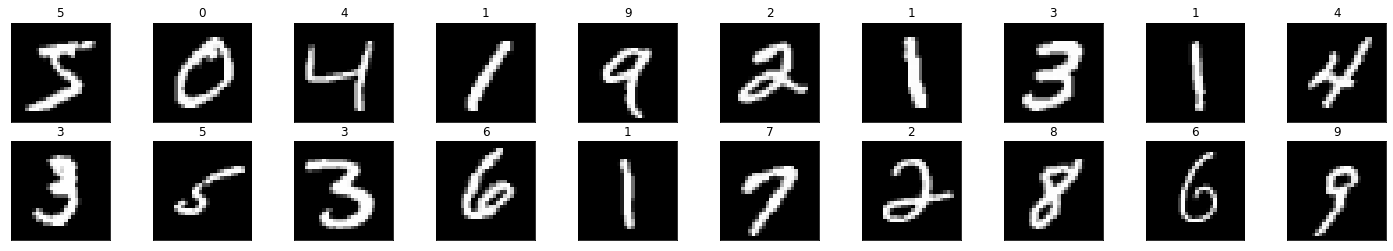

In [ ]:
visualize(mnist_data_train)

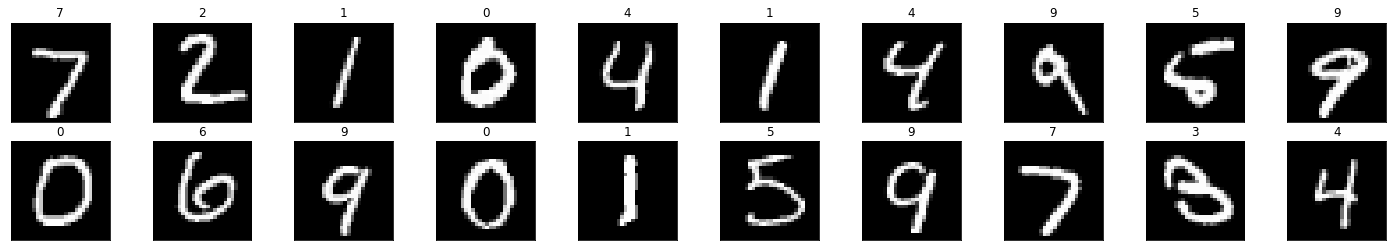

In [ ]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [8]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [9]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between = 100
    - total_shards (int): Number of shards to partition the data in = 200 
    - shards_size (int): Size of each shard = 300
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives = 2

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [10]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [11]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [12]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [13]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [14]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []


  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()
  
  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end-start))
  
  return model, train_loss, test_accuracy, test_loss

## Testing Loop

In [15]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))
  
  return test_accuracy, test_loss

In [16]:
log_dict = {}
NUM_REPEAT = 2

## MNIST CNN on Non IID

### Train


###**MNIST CNN Low**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.104
Round: 2... 	Average Loss: 0.067
Round: 3... 	Average Loss: 0.032
Round: 4... 	Average Loss: 0.033
Round: 5... 	Average Loss: 0.015
Round: 6... 	Average Loss: 0.026
Round: 7... 	Average Loss: 0.032
Round: 8... 	Average Loss: 0.015
Round: 9... 	Average Loss: 0.014
Round: 10... 	Average Loss: 0.022
Round: 11... 	Average Loss: 0.016
Round: 12... 	Average Loss: 0.013
Round: 13... 	Average Loss: 0.011
Round: 14... 	Average Loss: 0.02
Round: 15... 	Average Loss: 0.013
Round: 16... 	Average Loss: 0.015
Round: 17... 	Average Loss: 0.011
Round: 18... 	Average Loss: 0.011
Round: 19... 	Average Loss: 0.013
Round: 20... 	Average Loss: 0.011
Round: 21... 	Average Loss: 0.01
Round: 22... 	Average Loss: 0.009
Round: 23... 	Average Loss: 0.018
Round: 24... 	Average Loss: 0.009
Round: 25... 	Average Loss: 0.013
Round: 26... 	Average Loss: 0.009
Round: 27... 	Average Loss: 0.008
Round: 28... 	Average Loss: 0.012
Round: 29... 	Average Loss: 0.009

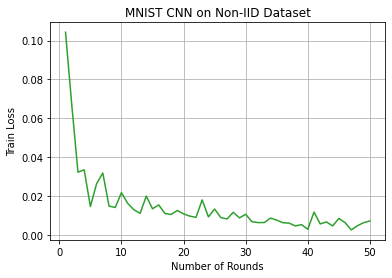

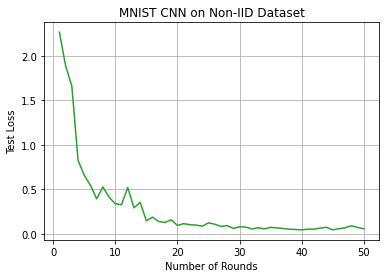

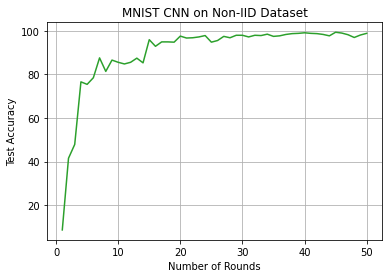

Training Done!
Total time taken to Train: 632.7394571304321


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.127
Round: 2... 	Average Loss: 0.063
Round: 3... 	Average Loss: 0.049
Round: 4... 	Average Loss: 0.039
Round: 5... 	Average Loss: 0.029
Round: 6... 	Average Loss: 0.024
Round: 7... 	Average Loss: 0.036
Round: 8... 	Average Loss: 0.025
Round: 9... 	Average Loss: 0.021
Round: 10... 	Average Loss: 0.017
Round: 11... 	Average Loss: 0.017
Round: 12... 	Average Loss: 0.022
Round: 13... 	Average Loss: 0.011
Round: 14... 	Average Loss: 0.014
Round: 15... 	Average Loss: 0.014
Round: 16... 	Average Loss: 0.014
Round: 17... 	Average Loss: 0.012
Round: 18... 	Average Loss: 0.017
Round: 19... 	Average Loss: 0.012
Round: 20... 	Average Loss: 0.01
Round: 21... 	Average Loss: 0.009
Round: 22... 	Average Loss: 0.019
Round: 23... 	Average Loss: 0.008
Round: 24... 	Average Loss: 0.01
Round: 25... 	Average Loss: 0.008
Round: 26... 	Average Loss: 0.016
Round: 27... 	Average Loss: 0.007
Round

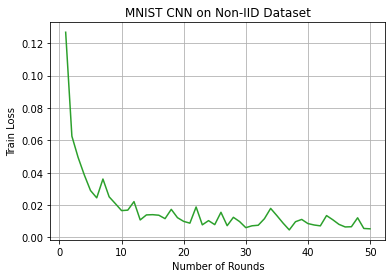

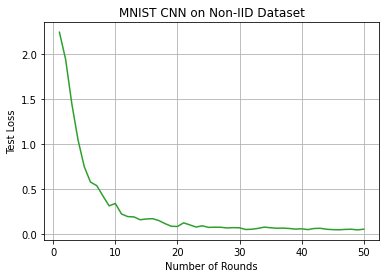

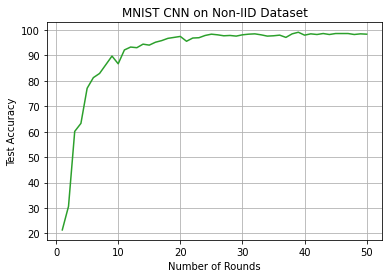

Training Done!
Total time taken to Train: 647.9071252346039




In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### **MNIS CNN Medium**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.236
Round: 2... 	Average Loss: 0.107
Round: 3... 	Average Loss: 0.06
Round: 4... 	Average Loss: 0.041
Round: 5... 	Average Loss: 0.038
Round: 6... 	Average Loss: 0.042
Round: 7... 	Average Loss: 0.031
Round: 8... 	Average Loss: 0.023
Round: 9... 	Average Loss: 0.028
Round: 10... 	Average Loss: 0.018
Round: 11... 	Average Loss: 0.014
Round: 12... 	Average Loss: 0.03
Round: 13... 	Average Loss: 0.019
Round: 14... 	Average Loss: 0.017
Round: 15... 	Average Loss: 0.021
Round: 16... 	Average Loss: 0.012
Round: 17... 	Average Loss: 0.025
Round: 18... 	Average Loss: 0.014
Round: 19... 	Average Loss: 0.02
Round: 20... 	Average Loss: 0.018
Round: 21... 	Average Loss: 0.016
Round: 22... 	Average Loss: 0.015
Round: 23... 	Average Loss: 0.013
Round: 24... 	Average Loss: 0.012
Round: 25... 	Average Loss: 0.014
Round: 26... 	Average Loss: 0.016
Round: 27... 	Average Loss: 0.011
Round: 28... 	Average Loss: 0.017
Round: 29... 	Average Loss: 0.011


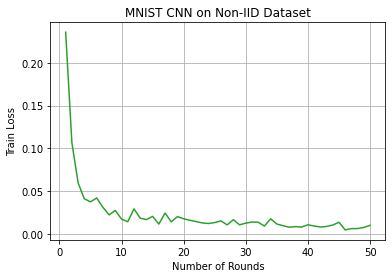

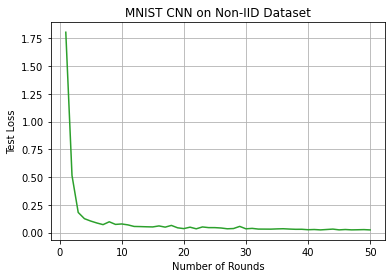

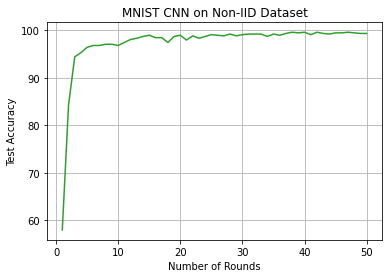

Training Done!
Total time taken to Train: 634.8248827457428


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.193
Round: 2... 	Average Loss: 0.109
Round: 3... 	Average Loss: 0.056
Round: 4... 	Average Loss: 0.041
Round: 5... 	Average Loss: 0.04
Round: 6... 	Average Loss: 0.038
Round: 7... 	Average Loss: 0.033
Round: 8... 	Average Loss: 0.027
Round: 9... 	Average Loss: 0.026
Round: 10... 	Average Loss: 0.036
Round: 11... 	Average Loss: 0.02
Round: 12... 	Average Loss: 0.021
Round: 13... 	Average Loss: 0.021
Round: 14... 	Average Loss: 0.022
Round: 15... 	Average Loss: 0.02
Round: 16... 	Average Loss: 0.017
Round: 17... 	Average Loss: 0.018
Round: 18... 	Average Loss: 0.021
Round: 19... 	Average Loss: 0.015
Round: 20... 	Average Loss: 0.013
Round: 21... 	Average Loss: 0.014
Round: 22... 	Average Loss: 0.016
Round: 23... 	Average Loss: 0.015
Round: 24... 	Average Loss: 0.018
Round: 25... 	Average Loss: 0.011
Round: 26... 	Average Loss: 0.014
Round: 27... 	Average Loss: 0.01
Round: 

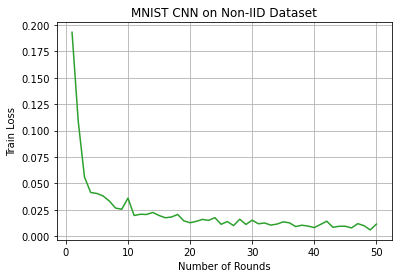

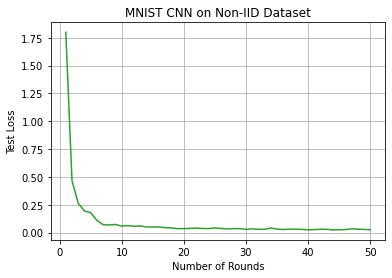

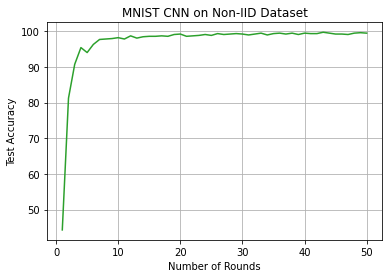

Training Done!
Total time taken to Train: 616.8449366092682




In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train,100, 500, 120, 5)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### **MNIST CNN High**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.345
Round: 2... 	Average Loss: 0.125
Round: 3... 	Average Loss: 0.082
Round: 4... 	Average Loss: 0.059
Round: 5... 	Average Loss: 0.044
Round: 6... 	Average Loss: 0.047
Round: 7... 	Average Loss: 0.038
Round: 8... 	Average Loss: 0.032
Round: 9... 	Average Loss: 0.032
Round: 10... 	Average Loss: 0.026
Round: 11... 	Average Loss: 0.029
Round: 12... 	Average Loss: 0.023
Round: 13... 	Average Loss: 0.027
Round: 14... 	Average Loss: 0.018
Round: 15... 	Average Loss: 0.021
Round: 16... 	Average Loss: 0.018
Round: 17... 	Average Loss: 0.016
Round: 18... 	Average Loss: 0.022
Round: 19... 	Average Loss: 0.016
Round: 20... 	Average Loss: 0.019
Round: 21... 	Average Loss: 0.016
Round: 22... 	Average Loss: 0.02
Round: 23... 	Average Loss: 0.015
Round: 24... 	Average Loss: 0.015
Round: 25... 	Average Loss: 0.019
Round: 26... 	Average Loss: 0.016
Round: 27... 	Average Loss: 0.015
Round: 28... 	Average Loss: 0.013
Round: 29... 	Average Loss: 0.01

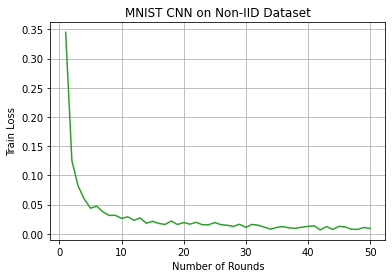

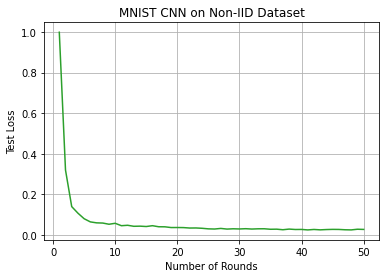

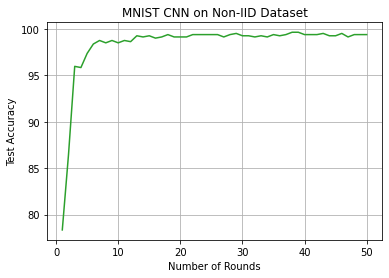

Training Done!
Total time taken to Train: 621.8385198116302


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.328
Round: 2... 	Average Loss: 0.141
Round: 3... 	Average Loss: 0.079
Round: 4... 	Average Loss: 0.049
Round: 5... 	Average Loss: 0.042
Round: 6... 	Average Loss: 0.043
Round: 7... 	Average Loss: 0.029
Round: 8... 	Average Loss: 0.036
Round: 9... 	Average Loss: 0.04
Round: 10... 	Average Loss: 0.02
Round: 11... 	Average Loss: 0.031
Round: 12... 	Average Loss: 0.028
Round: 13... 	Average Loss: 0.021
Round: 14... 	Average Loss: 0.027
Round: 15... 	Average Loss: 0.026
Round: 16... 	Average Loss: 0.019
Round: 17... 	Average Loss: 0.014
Round: 18... 	Average Loss: 0.018
Round: 19... 	Average Loss: 0.019
Round: 20... 	Average Loss: 0.018
Round: 21... 	Average Loss: 0.022
Round: 22... 	Average Loss: 0.015
Round: 23... 	Average Loss: 0.02
Round: 24... 	Average Loss: 0.016
Round: 25... 	Average Loss: 0.018
Round: 26... 	Average Loss: 0.014
Round: 27... 	Average Loss: 0.012
Round:

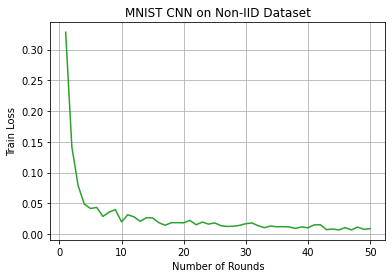

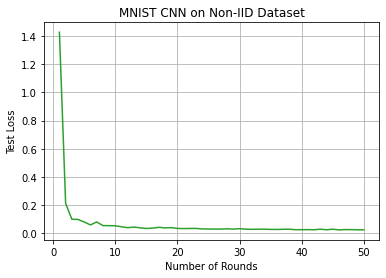

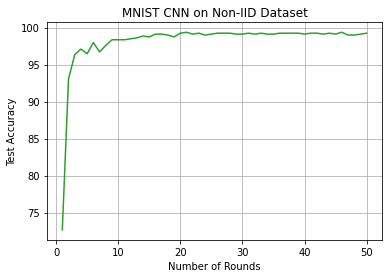

Training Done!
Total time taken to Train: 623.077766418457




In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train,100, 1000, 60, 10)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### Test

In [17]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

NameError: ignored

In [ ]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

### **MNIST MLP Low**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.115
Round: 2... 	Average Loss: 0.077
Round: 3... 	Average Loss: 0.048
Round: 4... 	Average Loss: 0.034
Round: 5... 	Average Loss: 0.032
Round: 6... 	Average Loss: 0.025
Round: 7... 	Average Loss: 0.026
Round: 8... 	Average Loss: 0.022
Round: 9... 	Average Loss: 0.03
Round: 10... 	Average Loss: 0.022
Round: 11... 	Average Loss: 0.022
Round: 12... 	Average Loss: 0.029
Round: 13... 	Average Loss: 0.024
Round: 14... 	Average Loss: 0.012
Round: 15... 	Average Loss: 0.017
Round: 16... 	Average Loss: 0.014
Round: 17... 	Average Loss: 0.017
Round: 18... 	Average Loss: 0.021
Round: 19... 	Average Loss: 0.017
Round: 20... 	Average Loss: 0.017
Round: 21... 	Average Loss: 0.009
Round: 22... 	Average Loss: 0.027
Round: 23... 	Average Loss: 0.013
Round: 24... 	Average Loss: 0.025
Round: 25... 	Average Loss: 0.015
Round: 26... 	Average Loss: 0.011
Round: 27... 	Average Loss: 0.019
Round: 28... 	Average Loss: 0.011
Round: 29... 	Average Loss: 0.01

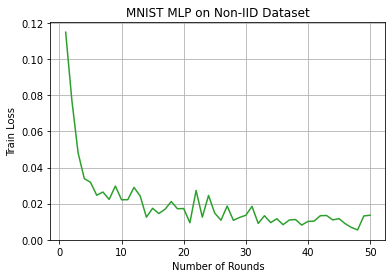

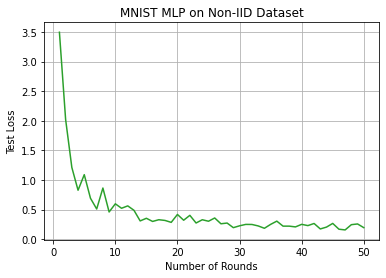

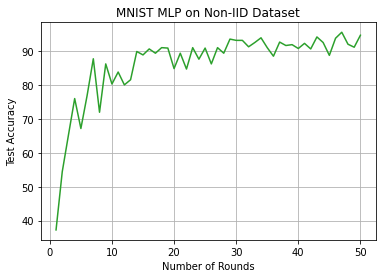

Training Done!
Total time taken to Train: 437.55665469169617


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.089
Round: 2... 	Average Loss: 0.058
Round: 3... 	Average Loss: 0.04
Round: 4... 	Average Loss: 0.04
Round: 5... 	Average Loss: 0.027
Round: 6... 	Average Loss: 0.027
Round: 7... 	Average Loss: 0.023
Round: 8... 	Average Loss: 0.021
Round: 9... 	Average Loss: 0.021
Round: 10... 	Average Loss: 0.017
Round: 11... 	Average Loss: 0.018
Round: 12... 	Average Loss: 0.029
Round: 13... 	Average Loss: 0.02
Round: 14... 	Average Loss: 0.028
Round: 15... 	Average Loss: 0.022
Round: 16... 	Average Loss: 0.016
Round: 17... 	Average Loss: 0.018
Round: 18... 	Average Loss: 0.018
Round: 19... 	Average Loss: 0.015
Round: 20... 	Average Loss: 0.015
Round: 21... 	Average Loss: 0.01
Round: 22... 	Average Loss: 0.007
Round: 23... 	Average Loss: 0.021
Round: 24... 	Average Loss: 0.016
Round: 25... 	Average Loss: 0.013
Round: 26... 	Average Loss: 0.027
Round: 27... 	Average Loss: 0.015
Round:

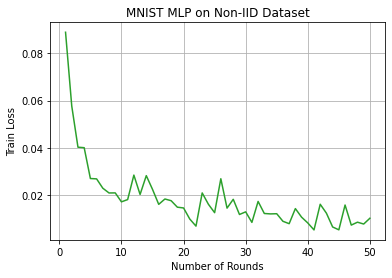

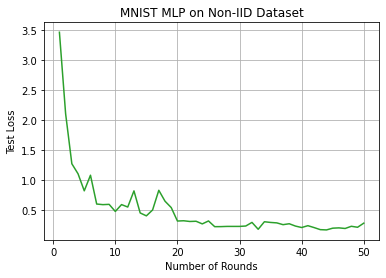

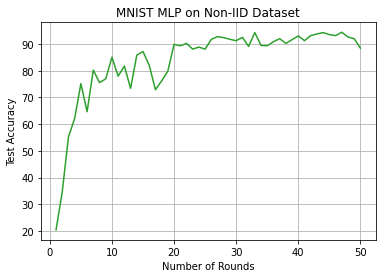

Training Done!
Total time taken to Train: 448.0314631462097




In [ ]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### **MNIST MLP Medium**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.217
Round: 2... 	Average Loss: 0.111
Round: 3... 	Average Loss: 0.098
Round: 4... 	Average Loss: 0.055
Round: 5... 	Average Loss: 0.042
Round: 6... 	Average Loss: 0.051
Round: 7... 	Average Loss: 0.053
Round: 8... 	Average Loss: 0.048
Round: 9... 	Average Loss: 0.051
Round: 10... 	Average Loss: 0.046
Round: 11... 	Average Loss: 0.035
Round: 12... 	Average Loss: 0.038
Round: 13... 	Average Loss: 0.047
Round: 14... 	Average Loss: 0.041
Round: 15... 	Average Loss: 0.029
Round: 16... 	Average Loss: 0.028
Round: 17... 	Average Loss: 0.024
Round: 18... 	Average Loss: 0.036
Round: 19... 	Average Loss: 0.027
Round: 20... 	Average Loss: 0.027
Round: 21... 	Average Loss: 0.025
Round: 22... 	Average Loss: 0.032
Round: 23... 	Average Loss: 0.029
Round: 24... 	Average Loss: 0.025
Round: 25... 	Average Loss: 0.019
Round: 26... 	Average Loss: 0.019
Round: 27... 	Average Loss: 0.021
Round: 28... 	Average Loss: 0.025
Round: 29... 	Average Loss: 0.0

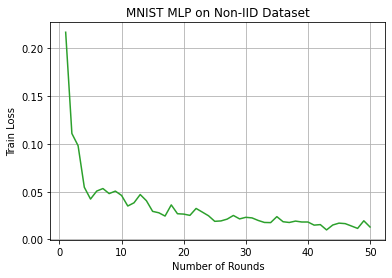

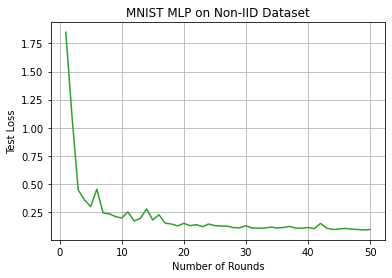

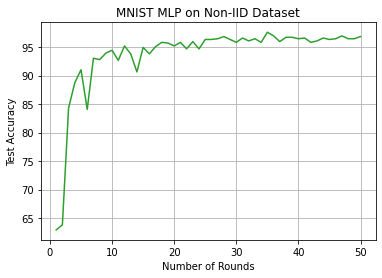

Training Done!
Total time taken to Train: 639.7177486419678


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.215
Round: 2... 	Average Loss: 0.116
Round: 3... 	Average Loss: 0.081
Round: 4... 	Average Loss: 0.058
Round: 5... 	Average Loss: 0.059
Round: 6... 	Average Loss: 0.066
Round: 7... 	Average Loss: 0.053
Round: 8... 	Average Loss: 0.053
Round: 9... 	Average Loss: 0.041
Round: 10... 	Average Loss: 0.043
Round: 11... 	Average Loss: 0.041
Round: 12... 	Average Loss: 0.043
Round: 13... 	Average Loss: 0.046
Round: 14... 	Average Loss: 0.041
Round: 15... 	Average Loss: 0.032
Round: 16... 	Average Loss: 0.027
Round: 17... 	Average Loss: 0.029
Round: 18... 	Average Loss: 0.033
Round: 19... 	Average Loss: 0.035
Round: 20... 	Average Loss: 0.023
Round: 21... 	Average Loss: 0.026
Round: 22... 	Average Loss: 0.027
Round: 23... 	Average Loss: 0.022
Round: 24... 	Average Loss: 0.032
Round: 25... 	Average Loss: 0.024
Round: 26... 	Average Loss: 0.024
Round: 27... 	Average Loss: 0.025
Rou

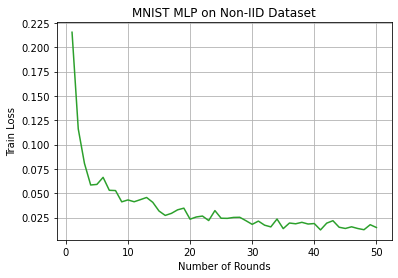

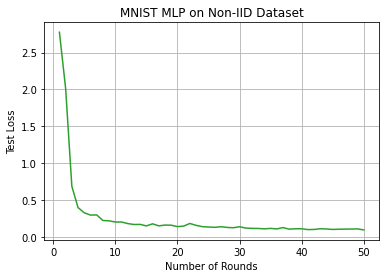

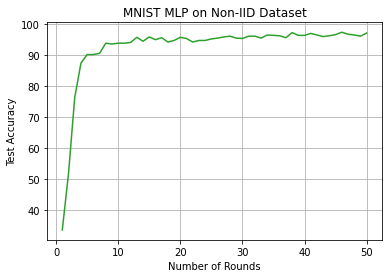

Training Done!
Total time taken to Train: 619.8946487903595




In [18]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 500, 120, 5)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### **MNIST MLP High**

Experiment Run Number:  0
Round: 1... 	Average Loss: 0.466
Round: 2... 	Average Loss: 0.141
Round: 3... 	Average Loss: 0.103
Round: 4... 	Average Loss: 0.096
Round: 5... 	Average Loss: 0.067
Round: 6... 	Average Loss: 0.064
Round: 7... 	Average Loss: 0.075
Round: 8... 	Average Loss: 0.056
Round: 9... 	Average Loss: 0.044
Round: 10... 	Average Loss: 0.051
Round: 11... 	Average Loss: 0.037
Round: 12... 	Average Loss: 0.043
Round: 13... 	Average Loss: 0.038
Round: 14... 	Average Loss: 0.043
Round: 15... 	Average Loss: 0.041
Round: 16... 	Average Loss: 0.032
Round: 17... 	Average Loss: 0.04
Round: 18... 	Average Loss: 0.04
Round: 19... 	Average Loss: 0.027
Round: 20... 	Average Loss: 0.035
Round: 21... 	Average Loss: 0.033
Round: 22... 	Average Loss: 0.026
Round: 23... 	Average Loss: 0.032
Round: 24... 	Average Loss: 0.025
Round: 25... 	Average Loss: 0.031
Round: 26... 	Average Loss: 0.032
Round: 27... 	Average Loss: 0.028
Round: 28... 	Average Loss: 0.025
Round: 29... 	Average Loss: 0.021

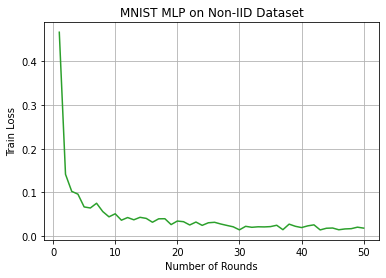

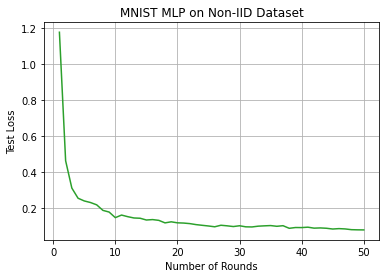

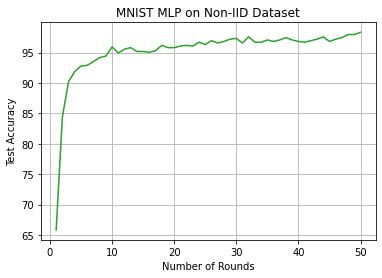

Training Done!
Total time taken to Train: 635.5394122600555


Experiment Run Number:  1
Round: 1... 	Average Loss: 0.427
Round: 2... 	Average Loss: 0.156
Round: 3... 	Average Loss: 0.106
Round: 4... 	Average Loss: 0.096
Round: 5... 	Average Loss: 0.088
Round: 6... 	Average Loss: 0.063
Round: 7... 	Average Loss: 0.062
Round: 8... 	Average Loss: 0.056
Round: 9... 	Average Loss: 0.061
Round: 10... 	Average Loss: 0.057
Round: 11... 	Average Loss: 0.041
Round: 12... 	Average Loss: 0.05
Round: 13... 	Average Loss: 0.045
Round: 14... 	Average Loss: 0.041
Round: 15... 	Average Loss: 0.032
Round: 16... 	Average Loss: 0.042
Round: 17... 	Average Loss: 0.032
Round: 18... 	Average Loss: 0.038
Round: 19... 	Average Loss: 0.033
Round: 20... 	Average Loss: 0.029
Round: 21... 	Average Loss: 0.03
Round: 22... 	Average Loss: 0.031
Round: 23... 	Average Loss: 0.027
Round: 24... 	Average Loss: 0.025
Round: 25... 	Average Loss: 0.031
Round: 26... 	Average Loss: 0.029
Round: 27... 	Average Loss: 0.027
Round

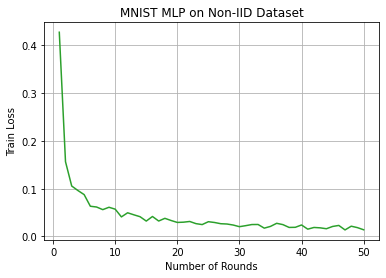

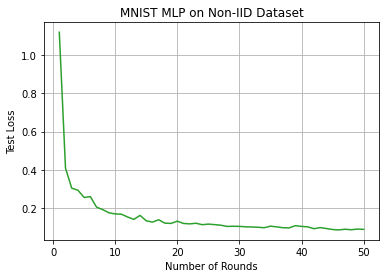

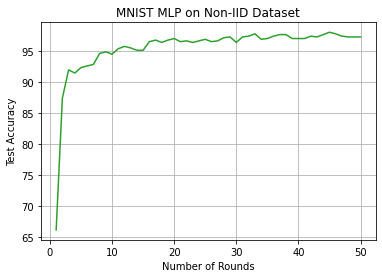

Training Done!
Total time taken to Train: 639.328914642334




In [19]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 1000, 60, 10)
  #   100, 500, 120, 5 - Medium
  #   100, 1000, 60, 10 - High
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss


### Test

In [20]:
criterion = nn.CrossEntropyLoss()
acc, loss = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.088758

Test Accuracy of     0: 98% (75/76)
Test Accuracy of     1: 95% (86/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 98% (72/73)
Test Accuracy of     4: 97% (87/89)
Test Accuracy of     5: 95% (65/68)
Test Accuracy of     6: 98% (61/62)
Test Accuracy of     7: 95% (77/81)
Test Accuracy of     8: 98% (76/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 97.342 (769.0/790.0)


In [21]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'hyperparams': hyperparams,
                                }

##Pickle Log

In [22]:
import pickle
 
with open(path + 'Skewness2shards_FedAvg.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [23]:
log_dict

{'MNIST MLP on Non IID': {'hyperparams': {'C': 0.1,
   'E': 5,
   'K': 100,
   'batch_size': 10,
   'lr': 0.05,
   'rounds': 50},
  'test_accuracy': [[65.82278481012658,
    84.43037974683544,
    90.25316455696202,
    91.89873417721519,
    92.78481012658227,
    92.9113924050633,
    93.54430379746836,
    94.17721518987342,
    94.43037974683544,
    95.9493670886076,
    94.9367088607595,
    95.56962025316456,
    95.82278481012658,
    95.18987341772151,
    95.18987341772151,
    95.0632911392405,
    95.31645569620254,
    96.20253164556962,
    95.82278481012658,
    95.82278481012658,
    96.07594936708861,
    96.20253164556962,
    96.07594936708861,
    96.70886075949367,
    96.32911392405063,
    96.9620253164557,
    96.58227848101266,
    96.83544303797468,
    97.21518987341773,
    97.34177215189874,
    96.58227848101266,
    97.59493670886076,
    96.70886075949367,
    96.70886075949367,
    97.0886075949367,
    96.83544303797468,
    97.0886075949367,
    97.46